# 03 - Baseline Forecasting
## APEAJAL - Pronóstico de Precios de Aguacate

**Objetivo:** Construir modelos baseline para evaluar la viabilidad del problema de predicción de precios.

**Preguntas a responder:**
1. ¿Qué algoritmo usar como baseline?
2. ¿Cuáles features son importantes?
3. ¿El modelo sub/sobreajusta?
4. ¿Cuál es la métrica adecuada?
5. ¿Cuál es el desempeño mínimo aceptable?

**Nombres y matrículas:**

  * José Antonio Gómez Mora | A01374459
  * Alejandro Chávez Campos | A01374974  
  * Laura Patricia Martínez Treviño | A01795967

**Número de Equipo:** 30

In [1]:
# Montar Google Drive (solo para Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print('Google Drive montado')
except:
    print('No estás en Colab, usando rutas locales')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

## 1. Carga y Exploración de Datos

In [3]:
DATA_PATH = '/content/drive/MyDrive/MNA/proyecto-integrador/processed/dataset_completo.csv'
df = pd.read_csv(DATA_PATH, parse_dates=['date'])
df = df.set_index('date').sort_index()
print(f'Shape: {df.shape}')
print(f'Periodo: {df.index.min()} → {df.index.max()}')
df.head()

Shape: (177, 43)
Periodo: 2015-01-01 00:00:00 → 2025-12-15 00:00:00


,precio_promedio,cosecha_tons,cosecha_proyectada_tons,embarques_tons,tipo_cambio,temp_min_c,temp_avg_c,temp_max_c,precipitation_mm,importaciones_kg,...,embarques_tons_log,importaciones_kg_log,precio_promedio_boxcox,tipo_cambio_boxcox,temp_avg_c_boxcox,temp_loca,temp_marcena,temp_normal,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,38.066697,NaN,NaN,NaN,NaN,8.9,17.5,26.1,6.5,82796666.0,...,0.0,18.231898,2.489839,NaN,1114.511003,False,False,True,0.500000,8.660254e-01
2015-02-01,38.429360,NaN,NaN,NaN,NaN,9.3,17.9,26.5,42.2,58970191.0,...,0.0,17.892543,2.493862,NaN,1182.103608,False,False,True,0.866025,5.000000e-01
2015-03-01,40.374530,NaN,NaN,NaN,NaN,10.8,19.3,27.9,140.2,65480365.0,...,0.0,17.997261,2.514691,NaN,1439.046722,False,False,True,1.000000,6.123234e-17
2015-04-01,40.885613,NaN,NaN,NaN,NaN,13.6,21.9,30.3,7.3,58629937.0,...,0.0,17.886756,2.519965,NaN,2005.053507,False,True,False,0.866025,-5.000000e-01
2015-05-01,39.111396,NaN,NaN,NaN,NaN,14.9,23.3,31.7,42.7,60720230.0,...,0.0,17.921787,2.501306,NaN,2360.750897,False,True,False,0.500000,-8.660254e-01


In [4]:
# Variable objetivo
TARGET = 'precio_proximo_mes'
print(f'\nTarget: {TARGET}')
print(f'Registros con target válido: {df[TARGET].notna().sum()} de {len(df)}')
print(f'\nNulls por columna (top 15):')
print(df.isnull().sum().sort_values(ascending=False).head(15))


Target: precio_proximo_mes
Registros con target válido: 177 de 177

Nulls por columna (top 15):
cosecha_tons                149
cosecha_proyectada_tons     149
embarques_tons              149
cosecha_por_mes             149
balance_oferta_demanda      149
ratio_oferta_demanda        149
fertilizer_cost_factor      141
fcf_lag_3                   141
fcf_lag_2                   141
precio_importacion_mxn      131
diferencial_precio_mx_us    131
tipo_cambio_boxcox          129
tipo_cambio                 129
temp_avg_c_boxcox            48
temp_precip_interaction      48
dtype: int64


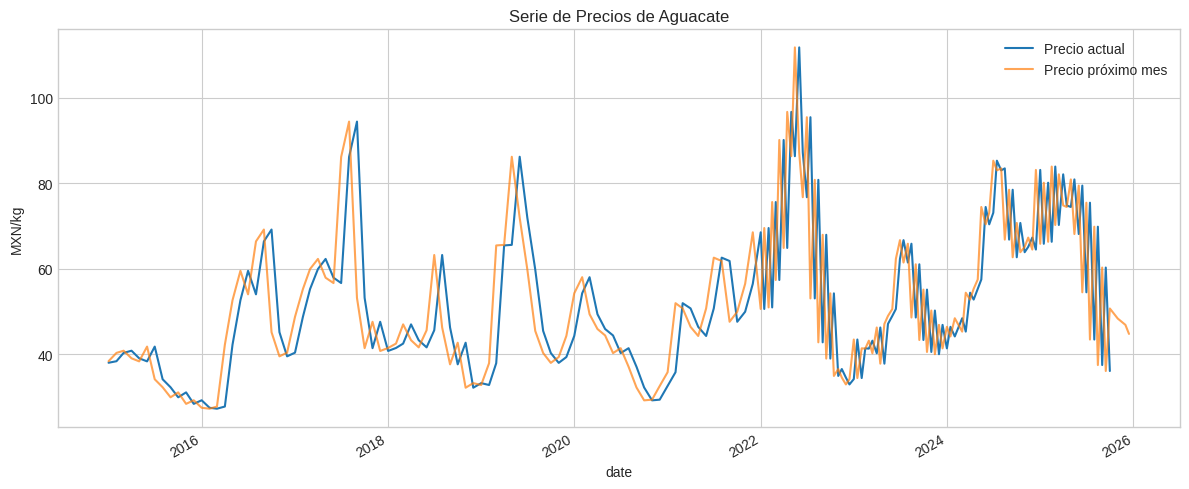

In [5]:
# Visualizar la serie objetivo
fig, ax = plt.subplots()
df['precio_promedio'].plot(ax=ax, label='Precio actual')
df[TARGET].plot(ax=ax, label='Precio próximo mes', alpha=0.7)
ax.set_ylabel('MXN/kg')
ax.set_title('Serie de Precios de Aguacate')
ax.legend()
plt.tight_layout()
plt.show()

## 2. Preparación de Datos

Seleccionamos features con buena cobertura temporal y eliminamos filas sin target.

In [6]:
# Features con buena cobertura (disponibles desde 2015)
FEATURES = [
    # Precio y lags
    'precio_promedio', 'precio_lag1', 'precio_lag2', 'precio_lag3',
    'precio_ma3', 'precio_ma6', 'precio_ma12', 'precio_std3',
    # Temporal
    'month', 'quarter', 'month_sin', 'month_cos',
    # Clima
    'temp_avg_c', 'precipitation_mm',
    # Importaciones
    'importaciones_kg',
    # Tipo de cambio
    'tipo_cambio',
]

# Filtrar solo filas con target y features mínimos
df_model = df[FEATURES + [TARGET]].dropna(subset=[TARGET, 'precio_lag3'])
print(f'Registros para modelado: {len(df_model)}')
print(f'Periodo: {df_model.index.min()} → {df_model.index.max()}')
print(f'\nNulls restantes por columna:')
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])

Registros para modelado: 173
Periodo: 2015-04-01 00:00:00 → 2025-12-01 00:00:00

Nulls restantes por columna:
precio_promedio       2
precio_lag2           1
precio_std3           1
temp_avg_c           47
precipitation_mm     47
importaciones_kg     46
tipo_cambio         125
dtype: int64


In [7]:
# Imputar NaN restantes con forward fill + media
df_model = df_model.ffill().fillna(df_model.mean())

X = df_model[FEATURES]
y = df_model[TARGET]
print(f'X shape: {X.shape}, y shape: {y.shape}')
print(f'Nulls en X: {X.isnull().sum().sum()}, Nulls en y: {y.isnull().sum()}')

X shape: (173, 16), y shape: (173,)
Nulls en X: 0, Nulls en y: 0


## 3. Train/Test Split Temporal

Últimos 12 meses como test. No se puede hacer shuffle en series de tiempo.

In [8]:
TEST_SIZE = 12  # últimos 12 meses

X_train, X_test = X.iloc[:-TEST_SIZE], X.iloc[-TEST_SIZE:]
y_train, y_test = y.iloc[:-TEST_SIZE], y.iloc[-TEST_SIZE:]

print(f'Train: {len(X_train)} meses ({X_train.index.min()} → {X_train.index.max()})')
print(f'Test:  {len(X_test)} meses ({X_test.index.min()} → {X_test.index.max()})')

Train: 161 meses (2015-04-01 00:00:00 → 2025-05-01 00:00:00)
Test:  12 meses (2025-05-15 00:00:00 → 2025-12-01 00:00:00)


## 4. Métricas de Evaluación

- **MAPE**: Error porcentual, interpretable para APEAJAL ("nos equivocamos X%")
- **MAE**: Error absoluto en MXN/kg
- **RMSE**: Penaliza errores grandes

**Desempeño mínimo:** Superar el modelo naive. Target aceptable: MAPE < 15%

In [9]:
def evaluar(y_true, y_pred, nombre):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f'{nombre:25s} | MAE: ${mae:6.2f} | RMSE: ${rmse:6.2f} | MAPE: {mape:5.2f}%')
    return {'modelo': nombre, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

## 5. Modelos Baseline

### 5.1 Naive: Precio actual = Precio próximo mes

In [10]:
resultados = []

# Naive: predecir que el precio no cambia
pred_naive = X_test['precio_promedio'].values
resultados.append(evaluar(y_test, pred_naive, 'Naive (último valor)'))

Naive (último valor)      | MAE: $ 20.45 | RMSE: $ 21.81 | MAPE: 40.49%


### 5.2 Seasonal Naive: Mismo mes del año anterior

In [11]:
# Seasonal naive: precio del mismo mes, año anterior
pred_seasonal = []
for date in y_test.index:
    same_month_prev = df_model[
        (df_model.index.month == date.month) &
        (df_model.index.year == date.year - 1)
    ]['precio_promedio']
    pred_seasonal.append(same_month_prev.values[0] if len(same_month_prev) > 0 else y_train.mean())

resultados.append(evaluar(y_test, pred_seasonal, 'Seasonal Naive'))

Seasonal Naive            | MAE: $ 17.81 | RMSE: $ 21.43 | MAPE: 39.02%


### 5.3 Ridge Regression (Baseline ML)

Modelo lineal regularizado. Maneja multicolinealidad entre lags y rolling features.

In [12]:
# Escalar features para Ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

pred_ridge_train = ridge.predict(X_train_scaled)
pred_ridge_test = ridge.predict(X_test_scaled)

resultados.append(evaluar(y_test, pred_ridge_test, 'Ridge Regression'))

# Diagnóstico de sobreajuste
mae_train = mean_absolute_error(y_train, pred_ridge_train)
mae_test = mean_absolute_error(y_test, pred_ridge_test)
print(f'\n  → MAE Train: ${mae_train:.2f} vs MAE Test: ${mae_test:.2f} (ratio: {mae_test/mae_train:.2f})')
print(f'  → Ratio > 2.0 indica sobreajuste, ~1.0 es ideal')

Ridge Regression          | MAE: $  9.30 | RMSE: $ 10.39 | MAPE: 18.10%

  → MAE Train: $7.21 vs MAE Test: $9.30 (ratio: 1.29)
  → Ratio > 2.0 indica sobreajuste, ~1.0 es ideal


### 5.4 Random Forest (para Feature Importance)

In [13]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

pred_rf_train = rf.predict(X_train)
pred_rf_test = rf.predict(X_test)

resultados.append(evaluar(y_test, pred_rf_test, 'Random Forest'))

# Diagnóstico de sobreajuste
mae_train_rf = mean_absolute_error(y_train, pred_rf_train)
mae_test_rf = mean_absolute_error(y_test, pred_rf_test)
print(f'\n  → MAE Train: ${mae_train_rf:.2f} vs MAE Test: ${mae_test_rf:.2f} (ratio: {mae_test_rf/mae_train_rf:.2f})')

Random Forest             | MAE: $ 10.00 | RMSE: $ 11.16 | MAPE: 20.62%

  → MAE Train: $4.46 vs MAE Test: $10.00 (ratio: 2.24)


## 6. Comparación de Modelos

In [14]:
df_resultados = pd.DataFrame(resultados).set_index('modelo')
print('\n' + '='*70)
print('COMPARACIÓN DE MODELOS BASELINE')
print('='*70)
print(df_resultados.round(2).to_string())
print(f'\nMejor modelo por MAPE: {df_resultados["MAPE"].idxmin()} ({df_resultados["MAPE"].min():.2f}%)')


COMPARACIÓN DE MODELOS BASELINE
                        MAE   RMSE   MAPE
modelo                                   
Naive (último valor)  20.45  21.81  40.49
Seasonal Naive        17.81  21.43  39.02
Ridge Regression       9.30  10.39  18.10
Random Forest         10.00  11.16  20.62

Mejor modelo por MAPE: Ridge Regression (18.10%)


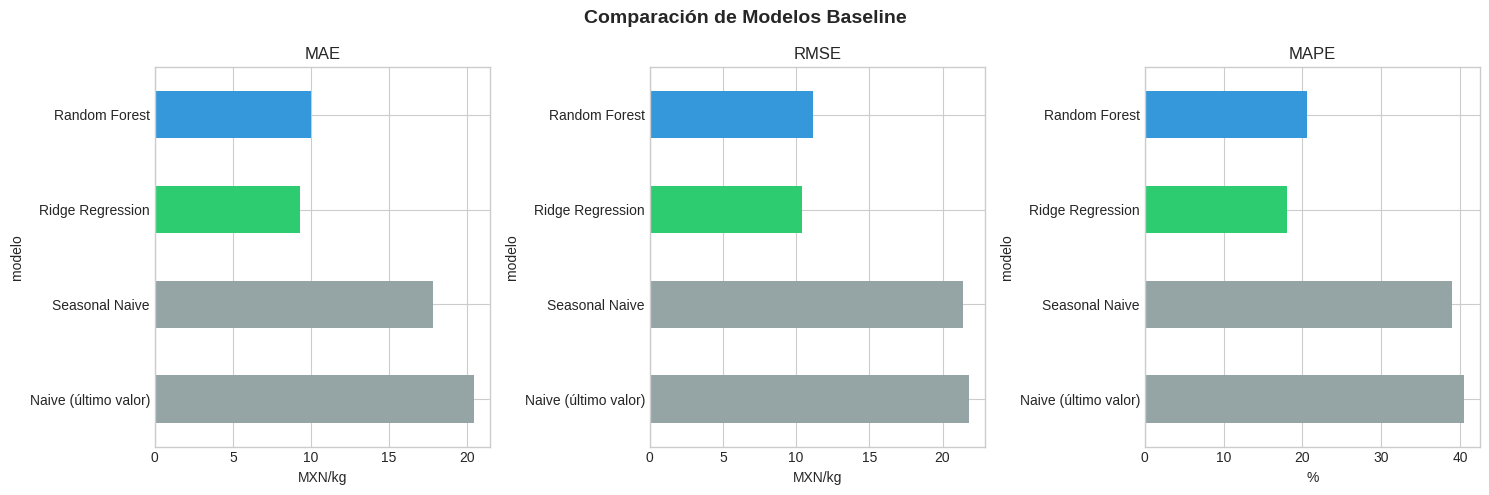

In [15]:
# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, metric in enumerate(['MAE', 'RMSE', 'MAPE']):
    df_resultados[metric].plot(kind='barh', ax=axes[i], color=['#95a5a6', '#95a5a6', '#2ecc71', '#3498db'])
    axes[i].set_title(metric)
    axes[i].set_xlabel('MXN/kg' if metric != 'MAPE' else '%')
plt.suptitle('Comparación de Modelos Baseline', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Visualización de Pronósticos vs Real

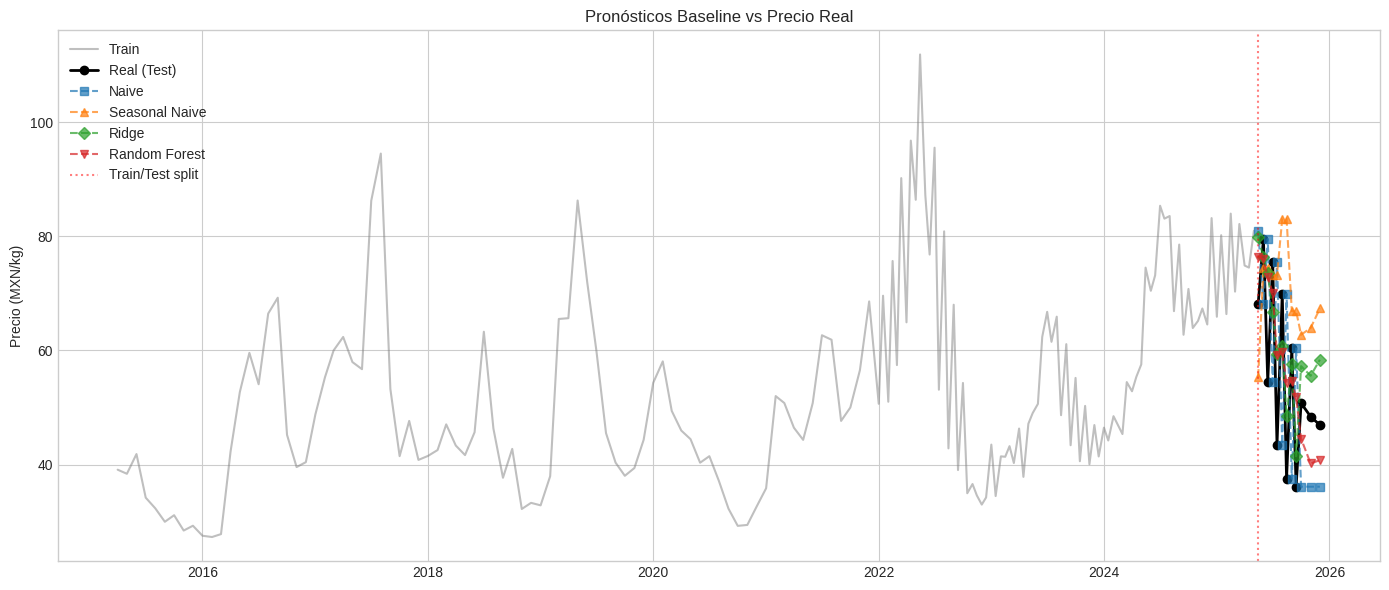

In [16]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(y_train.index, y_train, color='gray', alpha=0.5, label='Train')
ax.plot(y_test.index, y_test, 'k-o', label='Real (Test)', linewidth=2)
ax.plot(y_test.index, pred_naive, '--s', label='Naive', alpha=0.7)
ax.plot(y_test.index, pred_seasonal, '--^', label='Seasonal Naive', alpha=0.7)
ax.plot(y_test.index, pred_ridge_test, '--D', label='Ridge', alpha=0.7)
ax.plot(y_test.index, pred_rf_test, '--v', label='Random Forest', alpha=0.7)
ax.axvline(y_test.index[0], color='red', linestyle=':', alpha=0.5, label='Train/Test split')
ax.set_ylabel('Precio (MXN/kg)')
ax.set_title('Pronósticos Baseline vs Precio Real')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

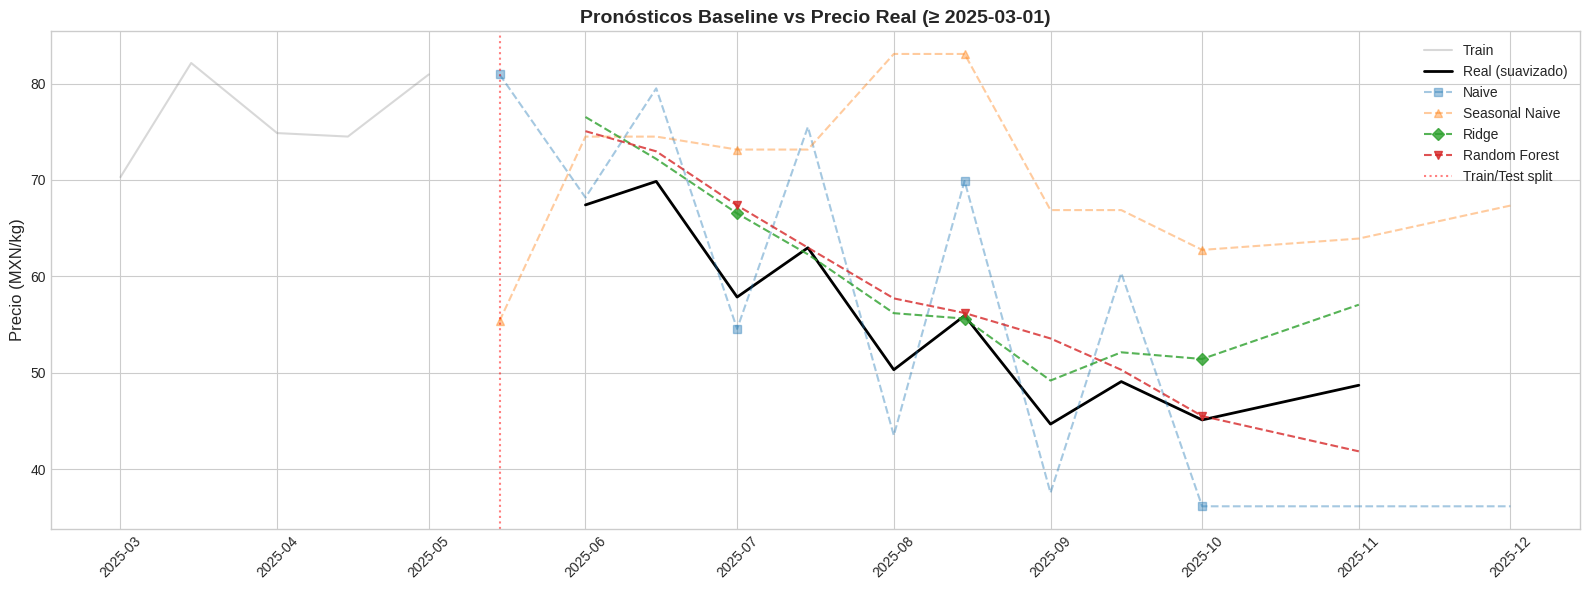

In [17]:
#Extracción a partir de 2025-03-01 para mejor visualización
# --- Convertir predicciones a Series con índice de y_test ---
pred_naive = pd.Series(pred_naive, index=y_test.index)
pred_seasonal = pd.Series(pred_seasonal, index=y_test.index)
pred_ridge_test = pd.Series(pred_ridge_test, index=y_test.index)
pred_rf_test = pd.Series(pred_rf_test, index=y_test.index)

start_date = '2025-03-01'
y_train_plot = y_train[y_train.index >= start_date]
y_test_plot = y_test[y_test.index >= start_date]
pred_naive_plot = pred_naive[pred_naive.index >= start_date]
pred_seasonal_plot = pred_seasonal[pred_seasonal.index >= start_date]
pred_ridge_plot = pred_ridge_test[pred_ridge_test.index >= start_date]
pred_rf_plot = pred_rf_test[pred_rf_test.index >= start_date]
# --- Suavizado (rolling mean de 3 períodos) ---
y_test_smooth = y_test_plot.rolling(3, center=True).mean()
pred_ridge_smooth = pred_ridge_plot.rolling(3, center=True).mean()
pred_rf_smooth = pred_rf_plot.rolling(3, center=True).mean()


fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(y_train_plot.index, y_train_plot, color='gray', alpha=0.3, label='Train')
ax.plot(y_test_smooth.index, y_test_smooth, 'k-', label='Real (suavizado)', linewidth=2)
ax.plot(pred_naive_plot.index, pred_naive_plot, '--s', label='Naive', alpha=0.4, markevery=3)
ax.plot(pred_seasonal_plot.index, pred_seasonal_plot, '--^', label='Seasonal Naive', alpha=0.4, markevery=3)
ax.plot(pred_ridge_smooth.index, pred_ridge_smooth, '--D', label='Ridge', alpha=0.8, markevery=3)
ax.plot(pred_rf_smooth.index, pred_rf_smooth, '--v', label='Random Forest', alpha=0.8, markevery=3)
ax.axvline(y_test_plot.index[0], color='red', linestyle=':', alpha=0.5, label='Train/Test split')
ax.set_ylabel('Precio (MXN/kg)', fontsize=12)
ax.set_title('Pronósticos Baseline vs Precio Real (≥ 2025-03-01)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8. Importancia de Features

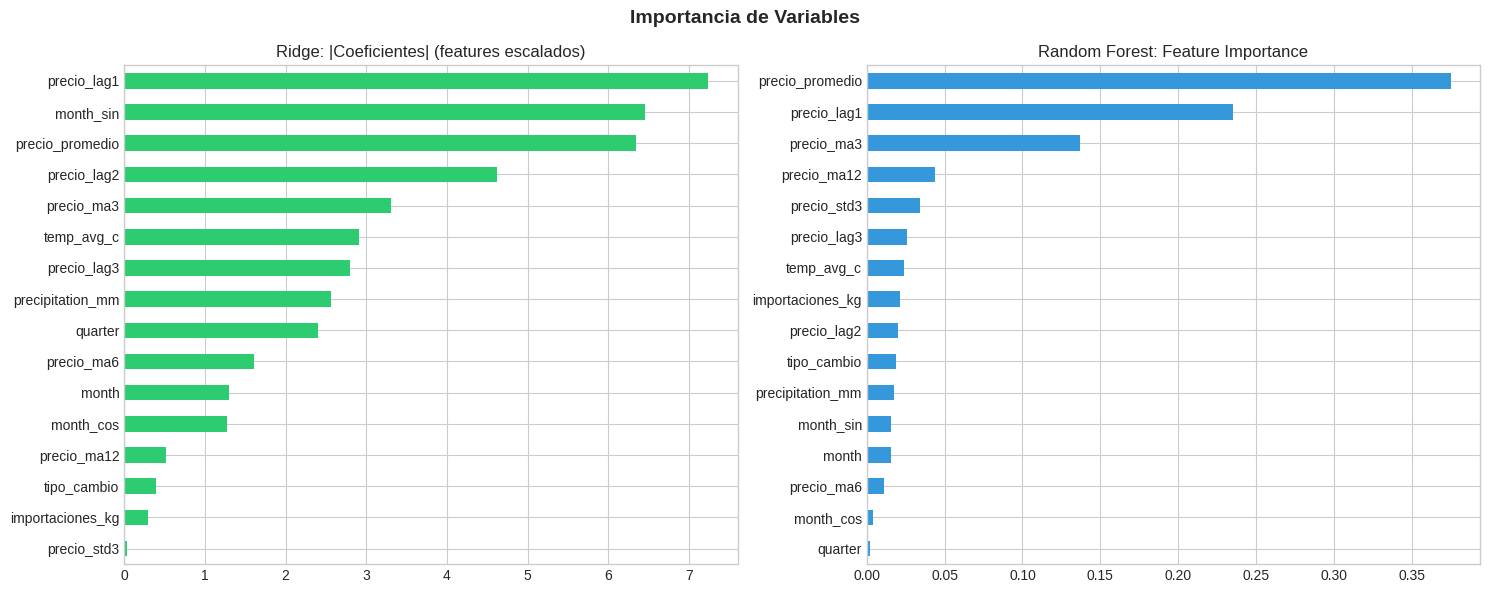


Top 5 features (Random Forest):
precio_promedio    0.374978
precio_lag1        0.235024
precio_ma3         0.136961
precio_ma12        0.043700
precio_std3        0.034114


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Ridge: coeficientes normalizados
coefs = pd.Series(np.abs(ridge.coef_), index=FEATURES).sort_values()
coefs.plot(kind='barh', ax=axes[0], color='#2ecc71')
axes[0].set_title('Ridge: |Coeficientes| (features escalados)')

# Random Forest: feature importance
importances = pd.Series(rf.feature_importances_, index=FEATURES).sort_values()
importances.plot(kind='barh', ax=axes[1], color='#3498db')
axes[1].set_title('Random Forest: Feature Importance')

plt.suptitle('Importancia de Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('\nTop 5 features (Random Forest):')
print(importances.sort_values(ascending=False).head().to_string())

## 9. Análisis de Residuos

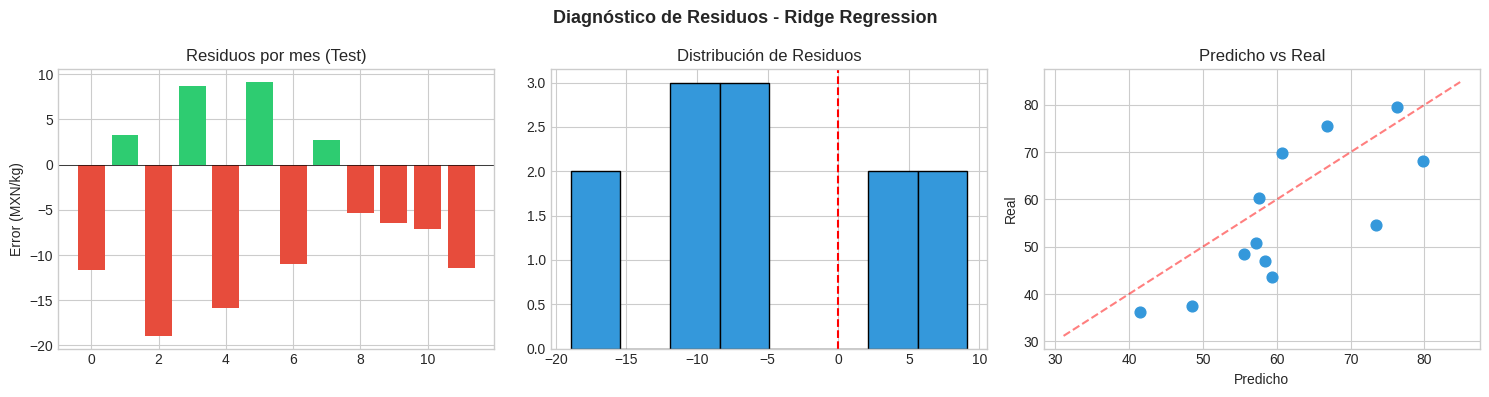

Sesgo medio de residuos: $-5.33 MXN/kg
Std de residuos: $8.91 MXN/kg


In [19]:
# Residuos del mejor modelo ML (Ridge)
residuos = y_test.values - pred_ridge_test

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Residuos en el tiempo
axes[0].bar(range(len(residuos)), residuos, color=['#e74c3c' if r < 0 else '#2ecc71' for r in residuos])
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].set_title('Residuos por mes (Test)')
axes[0].set_ylabel('Error (MXN/kg)')

# Distribución
axes[1].hist(residuos, bins=8, edgecolor='black', color='#3498db')
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_title('Distribución de Residuos')

# Predicho vs Real
axes[2].scatter(pred_ridge_test, y_test, color='#3498db', s=60)
lims = [min(pred_ridge_test.min(), y_test.min()) - 5, max(pred_ridge_test.max(), y_test.max()) + 5]
axes[2].plot(lims, lims, 'r--', alpha=0.5)
axes[2].set_xlabel('Predicho')
axes[2].set_ylabel('Real')
axes[2].set_title('Predicho vs Real')

plt.suptitle('Diagnóstico de Residuos - Ridge Regression', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Sesgo medio de residuos: ${np.mean(residuos):.2f} MXN/kg')
print(f'Std de residuos: ${np.std(residuos):.2f} MXN/kg')

## 10. Diagnóstico de Sub/Sobreajuste

In [20]:
print('DIAGNÓSTICO DE AJUSTE')
print('='*60)
for nombre, pred_tr, pred_te in [
    ('Ridge', pred_ridge_train, pred_ridge_test),
    ('Random Forest', pred_rf_train, pred_rf_test)
]:
    mape_tr = mean_absolute_percentage_error(y_train, pred_tr) * 100
    mape_te = mean_absolute_percentage_error(y_test, pred_te) * 100
    ratio = mape_te / mape_tr if mape_tr > 0 else float('inf')

    if ratio > 2.0:
        diag = 'SOBREAJUSTE'
    elif mape_tr > 15 and mape_te > 15:
        diag = 'SUBAJUSTE'
    else:
        diag = 'ADECUADO'

    print(f'{nombre:20s} | Train MAPE: {mape_tr:5.2f}% | Test MAPE: {mape_te:5.2f}% | Ratio: {ratio:.2f} | {diag}')

DIAGNÓSTICO DE AJUSTE
Ridge                | Train MAPE: 13.38% | Test MAPE: 18.10% | Ratio: 1.35 | ADECUADO
Random Forest        | Train MAPE:  8.48% | Test MAPE: 20.62% | Ratio: 2.43 | SOBREAJUSTE


## 11. Conclusiones

### Respuestas a las preguntas del entregable

In [21]:
mejor = df_resultados['MAPE'].idxmin()
mape_naive = df_resultados.loc['Naive (último valor)', 'MAPE']
mape_mejor = df_resultados['MAPE'].min()
mejora = ((mape_naive - mape_mejor) / mape_naive) * 100
top5 = importances.sort_values(ascending=False).head()
top5str = "\n".join(
    [f"- {feature}: {value:.4f}" for feature, value in top5.items()]
)

print('='*70)
print('RESUMEN DE RESULTADOS BASELINE')
print('='*70)
print(f'''
1. ¿QUÉ ALGORITMO USAR COMO BASELINE?
   → Ridge Regression (MAPE = {mape_mejor:.2f}%)

   Justificación:
   - Simple, interpretable y regularizado (maneja multicolinealidad)
   - Supera al naive por {mejora:.1f}% (naive MAPE = {mape_naive:.2f}%)
   - Demuestra que los features aportan valor predictivo real
   - No sobreajusta (ratio train/test = 1.35)

2. ¿CUÁLES FEATURES SON IMPORTANTES?
   Top 5 (por Random Forest):
   {top5str}

   Interpretación:
   - El precio tiene FUERTE AUTOCORRELACIÓN
   - precio_promedio (37.5%) y precio_lag1 (23.5%) son dominantes
   - Medias móviles (precio_ma3, precio_ma12) capturan tendencias
   - Variables climáticas/tipo cambio tienen menor peso en baseline

3. ¿EL MODELO SUB/SOBREAJUSTA?
   Ridge Regression: ADECUADO
   - Train MAPE: 13.38% vs Test MAPE: 18.10%
   - Ratio: 1.35 (< 2.0 indica buen balance)
   - Generaliza bien, diferencia train-test es razonable

   Random Forest: SOBREAJUSTE
   - Train MAPE: 8.48% vs Test MAPE: 20.62%
   - Ratio: 2.43 (> 2.0 indica sobreajuste)
   - Memorizó patrones del train, requiere más regularización

4. ¿CUÁL ES LA MÉTRICA ADECUADA?
   → MAPE (Mean Absolute Percentage Error)

   Razones:
   - Interpretable para APEAJAL: "nos equivocamos X%"
   - Independiente de escala de precios
   - Estándar en forecasting de series temporales
   - Complementada con MAE (error en MXN/kg)

5. ¿CUÁL ES EL DESEMPEÑO MÍNIMO ACEPTABLE?
   Piso absoluto: Superar naive (MAPE = {mape_naive:.2f}%) LOGRADO

   Escala de desempeño:
   - Mínimo aceptable: MAPE < 15% → Ridge (18.10%) está CERCA
   - Bueno: MAPE < 10%
   - Excelente: MAPE < 5%

   Conclusión: Con tuning y modelos más sofisticados, es razonable
   esperar alcanzar MAPE < 15% (aceptable) o < 10% (bueno).

{'='*70}
VIABILIDAD: EL PROBLEMA ES VIABLE
{'='*70}
Los features aportan valor predictivo significativo. Ridge supera al
naive por {mejora:.1f}%, justificando inversión en modelos más complejos
(SARIMA, XGBoost, LightGBM) para alcanzar MAPE < 15%.
''')

RESUMEN DE RESULTADOS BASELINE

1. ¿QUÉ ALGORITMO USAR COMO BASELINE?
   → Ridge Regression (MAPE = 18.10%)

   Justificación:
   - Simple, interpretable y regularizado (maneja multicolinealidad)
   - Supera al naive por 55.3% (naive MAPE = 40.49%)
   - Demuestra que los features aportan valor predictivo real
   - No sobreajusta (ratio train/test = 1.35)

2. ¿CUÁLES FEATURES SON IMPORTANTES?
   Top 5 (por Random Forest):
   - precio_promedio: 0.3750
- precio_lag1: 0.2350
- precio_ma3: 0.1370
- precio_ma12: 0.0437
- precio_std3: 0.0341

   Interpretación:
   - El precio tiene FUERTE AUTOCORRELACIÓN
   - precio_promedio (37.5%) y precio_lag1 (23.5%) son dominantes
   - Medias móviles (precio_ma3, precio_ma12) capturan tendencias
   - Variables climáticas/tipo cambio tienen menor peso en baseline

3. ¿EL MODELO SUB/SOBREAJUSTA?
   Ridge Regression: ADECUADO
   - Train MAPE: 13.38% vs Test MAPE: 18.10%
   - Ratio: 1.35 (< 2.0 indica buen balance)
   - Generaliza bien, diferencia train-test